# 22.46 Procesamiento Adaptativo de Señales Aleatorias
# Proyecto 01
## Cancelación Activa de Ruido
Este trabajo desarrolla la síntesis de un sistema de cancelación activa de ruido.

<center><img src="../support/drawing/general_system.png" style='width: 640px;'></center>

#### Grupo N° 1
* DAVIDOV, Gonzalo Joaquín
* FARALL, Facundo David
* KAMMANN, Lucas Agustín
* TROZZO, Rafael Nicolás

In [1]:
import matplotlib.pyplot as plt

In [2]:
from scipy import signal

In [3]:
from scipy import linalg

In [4]:
import numpy as np

In [5]:
import IPython

In [872]:
def plot_anc_results(e, w=None, weight_plot='response'):
    """ Plot the results of the ANC algorithm.
        @param error_history
        @param weight_history
    """
    fig, ax = plt.subplots(2 if w is not None else 1, 1, figsize=(18, 18 if w is not None else 9))
    
    error_ax = ax[0] if w is not None else ax
    for error in e:
        error_ax.plot(error)
    error_ax.set_ylabel('$e(n)$', fontsize=16)
    error_ax.set_xlabel('$n$', fontsize=16)
    error_ax.grid()
    
    if w is not None:
        if weight_plot == 'response':
            ax[1].stem(w, use_line_collection=True)
            ax[1].set_ylabel('$w_n$', fontsize=16)
            ax[1].set_xlabel('$n$', fontsize=16)
            ax[1].grid()
        elif weight_plot == 'history':
            for i in range(w.shape[0]):
                ax[1].plot(w[i,:])
            ax[1].set_ylabel('$w_i(n)$', fontsize=16)
            ax[1].set_xlabel('$n$', fontsize=16)
            ax[1].grid()
    
    plt.show()

# 1. Introducción
El esquema ilustrado permite describir el comportamiento real en un sistema acústico, como son auriculares. Para la validación del comportamiento del sistema propuesto, se utilizarán bases de datos con mediciones realizadas sobre sistemas físicos reales, para simular su respuesta y operar el cancelador activo de ruido sobre ella.


<table>
    <tr>
        <td><center><img src="../support/drawing/headphone_system.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/headphone_paths.png" style='width: 500px;'></center></td>
    </tr>
</table>


## 1.1. Selección de señal de ruido
En esta sección, se selecciona la señal de ruido $x(n)$ que se utilizará para simular condiciones en un ambiente ruidoso, y se estudian sus aspectos característicos.

### 1.1.1. Ruido blanco gaussiano

In [7]:
# Create noise samples to stimulate the acoustic system and
# validate whether the active noise cancelling system is working
fs = 48000                        # Sampling frequency
tt = 1                            # Total time of simulation
dtt = int(fs * tt)                # Discrete total time of simuluation
white_noise = [np.random.normal(size=dtt), "White"]

### 1.1.2. Ruidos de muestras reales

In [8]:
from scipy.io.wavfile import read

In [9]:
airport_noise = [np.array(read("../samples/airport.wav")[1], dtype=float), "Airport"]
car_noise = [np.array(read("../samples/car.wav")[1], dtype=float), "Car"]
exhibition_noise = [np.array(read("../samples/exhibition.wav")[1], dtype=float), "Exhibition"]
restaurant_noise = [np.array(read("../samples/restaurant.wav")[1], dtype=float), "Restaurant"]
street_noise = [np.array(read("../samples/street.wav")[1], dtype=float), "Street"]
subway_noise = [np.array(read("../samples/subway.wav")[1], dtype=float), "Subway"]
train_noise = [np.array(read("../samples/train.wav")[1], dtype=float), "Train"]

### 1.1.3. Selección de ruido a utilizar

In [10]:
noise = subway_noise
x = noise[0]
x /= x.max()
noise_label = noise[1]

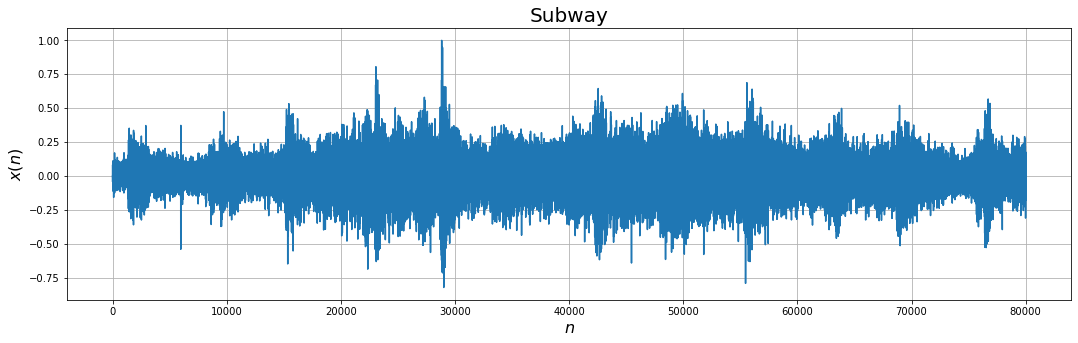

In [11]:
# Plot the input noise
plt.figure(figsize=(18, 5))
plt.plot(x)
plt.ylabel('$x(n)$', fontsize=16)
plt.xlabel('$n$', fontsize=16)
plt.title(noise_label, fontsize=20)
plt.grid()
plt.show()

In [12]:
# Listen the noise
IPython.display.Audio(x, rate=fs)

## 1.2. Simulación del sistema acústico
En esta sección, se construye un modelo matemático para simular el comportamiento del sistema acústico sobre el cual se desea aplicar la cancelación activa de ruido.

In [13]:
import json

In [14]:
class AcousticModel:
    """ The AcousticModel class exposes an inteface to simulate the interaction
        with the physical system. This allows us to encapsulate the physical model
        to easily simulate it while developing the active noise cancelling system.
    """
    
    def __init__(self):
        raise NotImplemented
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        raise NotImplemented
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        raise NotImplemented

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        raise NotImplemented
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        raise NotImplemented
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        raise NotImplemented
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        raise NotImplemented
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        raise NotImplemented

In [908]:
class BoseQC20(AcousticModel):
    """ Acoustic simulation of the BoseQC20 headphones based on the measurements
        performed by 
            'Acoust path database for ANC in-ear headphone development'
            Stefan LIEABICH, Johannes FABRY, Peter JAX, Peter VARY

        NOTE: It only supports simulating the primary acoustic path
    """
    
    def __init__(self, filepath, secondary_enable=False):
        """ Initializes the BoseQC20 instance
            @param filepath Filepath to the JSON file containing the dataset
        """
        
        # Open the JSON file containing measurements of the BoseQC20 headphones
        self.acoustic_paths_filepath = filepath
        self.acoustic_paths_file = open(self.acoustic_paths_filepath, 'r')
        self.acoustic_paths_data = json.load(self.acoustic_paths_file)
        
        # Choose the physical or acoustic paths from the dataset
        self.p = self.acoustic_paths_data['anechoic_chamber']['primary'][0][0]          # Primary acoustic path impulse response estimation
        self.g = self.acoustic_paths_data['anechoic_chamber']['secondary'][0]           # Secondary acoustic path impulse response estimation
        self.f = self.acoustic_paths_data['anechoic_chamber']['feedback'][0]            # Feedback acoustic path impulse response estimation
        
        # Cut the responses
        self.p = np.array(self.p[:2000])
        self.g = np.array(self.g[:150])
#         self.g = np.array([0] * 14 + [0.25])
        
        # Initialize internal signals
        self.x = None                                                              # Input signal of the acoustic model for simulation
        self.y = np.zeros(len(self.g))                                             # Saves the speaker sample
        self.n = -1                                                                # Current sampling time or instant
        self.secondary_enable = secondary_enable                                   # Whether the secondary acoustic path is simulated
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        return len(self.x)
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        # Set the noise samples
        self.x = x
        
        # Calculate the response of the primary acoustic path
        self.d = signal.lfilter(self.p, [1.0], self.x)

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        return self.x[self.n]
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        if self.secondary_enable:
            return self.d[self.n] + np.dot(self.g, self.y)
        else:
            return self.d[self.n] + self.y[0]
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        self.y = np.roll(self.y, 1)
        self.y[0] = y
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        if self.n < len(self.x) - 1:
            self.n += 1
            return True
        else:
            return False
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        self.n = -1

In [16]:
class Primary(AcousticModel):
    """ Acoustic model of the primary path.
    """
    
    def __init__(self):
        self.x = None                                       # Input signal of the acoustic model
        self.y = None                                       # Buffering for the secondary acoustic path
        self.n = -1                                         # Current sampling time or instant
    
    def __len__(self):
        """ Returns the length of the acoustic model, understood as the amount
            of samples for simulation that it contains.
        """
        return len(self.x)
    
    def set_noise(self, x):
        """ Set the noise samples
            @param x Array containing noise samples for the acoustic simulation
        """
        # Set the noise samples
        self.x = x
        
        # Calculate the response of the primary acoustic path
        self.d = signal.lfilter(np.ones(10) / 10, [1.0], x) # Response of the primary acoustic path

    def reference_microphone(self):
        """ Takes a sample from the reference microphone.
            @return Reference signal sample
        """
        return self.x[self.n]
    
    def error_microphone(self):
        """ Takes a sample from the error microphone.
            @return Error signal sample
        """
        return self.d[self.n] + self.y
    
    def speaker(self, y):
        """ Sets the output sample for the speaker.
            @param y Output signal sample
        """
        self.y = y
    
    def step(self):
        """ Moves forward to the next sampling time or instant.
            @return Boolean indicating it has not reached the end of the samples
        """
        if self.n < len(self.x) - 1:
            self.n += 1
            return True
        else:
            return False
    
    def reset(self):
        """ Resets the sampling time to zero.
        """
        self.n = -1

# 2. Modelado del camino acústico primario $P(z)$
En esta sección, se propone una primera iteración del sistema para modelar el camino acústico primario.

<table>
    <tr>
        <td><center><img src="../support/drawing/scheme_iteration_01.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/algorithm_iteration_01.png" style='width: 600px;'></center></td>
    </tr>
</table>

Se utilizará el ruido blanco para estudiar el comportamiento de esta iteración

In [17]:
x = white_noise[0]
x /= x.max()

In [18]:
import time

In [19]:
def anc_montecarlo(iterations, model, anc, size, order, step):
    """ Run a montecarlo simulation for the ANC system provided.
        @param iterations Amount of iterations for the simulation
        @param model Instance of an AcousticModel
        @param anc Function that executes the active noise cancelling
        @param size Amount of samples for iteration
        @param order Order of the FIR for the adaptive filter
        @param step Step size for LMS based algorithm
        @return Error and coefficients evolution for each iteration
    """
    
    # Create an instance of the acoustic model to be used
    # and generate a sample function of the input noise x(n)
    # to run the simulation. We are using white gaussian noise.
    noise = np.random.normal(size=size)
    model.set_noise(noise)
    
    # Initialize arrays used to register the error and coefficients
    # to be averaged and plotted at the end of the montecarlo simulation
    e = np.zeros((iterations, size))
    w = np.zeros((iterations, order, size))
    
    # Run each simulation
    for i in range(iterations):
        print(f'Running simulation {i + 1} of {iterations}')
        start_time = time.time()
        e_i, w_i = anc(model, order, step)
        end_time = time.time()
        e[i,:] = e_i
        w[i,:,:] = w_i
        model.reset()
        print(f'Finished in {np.round(end_time - start_time, 5)} s')
    
    # Return simulation results
    return e, w

In [20]:
def anc_primary(model, order, step):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path.
        
        @param model Instance of an acoustic model for simulation
        @param order Order of the filter
        @param step Step size used for LMS
        @return Tuple containing the error signal and the coefficients evolution
                (error_signal, coefficients_evolution)
    """
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    r = np.zeros(order)
    w = np.zeros(order)
    e_n = np.zeros(N)
    w_n = np.zeros((order, N))
    i = 0
    
    # Sample processing loop
    while (model.step()):
        # Take a new input sample and update the input buffer of the digital filter
        # by rolling the numpy array one place and introducing the new sample
        r = np.roll(r, 1)
        r[0] = model.reference_microphone()

        # Compute the output sample
        y = -np.dot(w, r)
        model.speaker(y)

        # Take a new error sample
        e = model.error_microphone()

        # Update the digital filter coefficients
        w += step * r * e

        # Save history
        e_n[i] = e
        w_n[:,i] = w
        i += 1
    
    return e_n, w_n

In [21]:
headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
it1_e, it1_w = anc_primary(headphone, order=2000, step=0.0015)

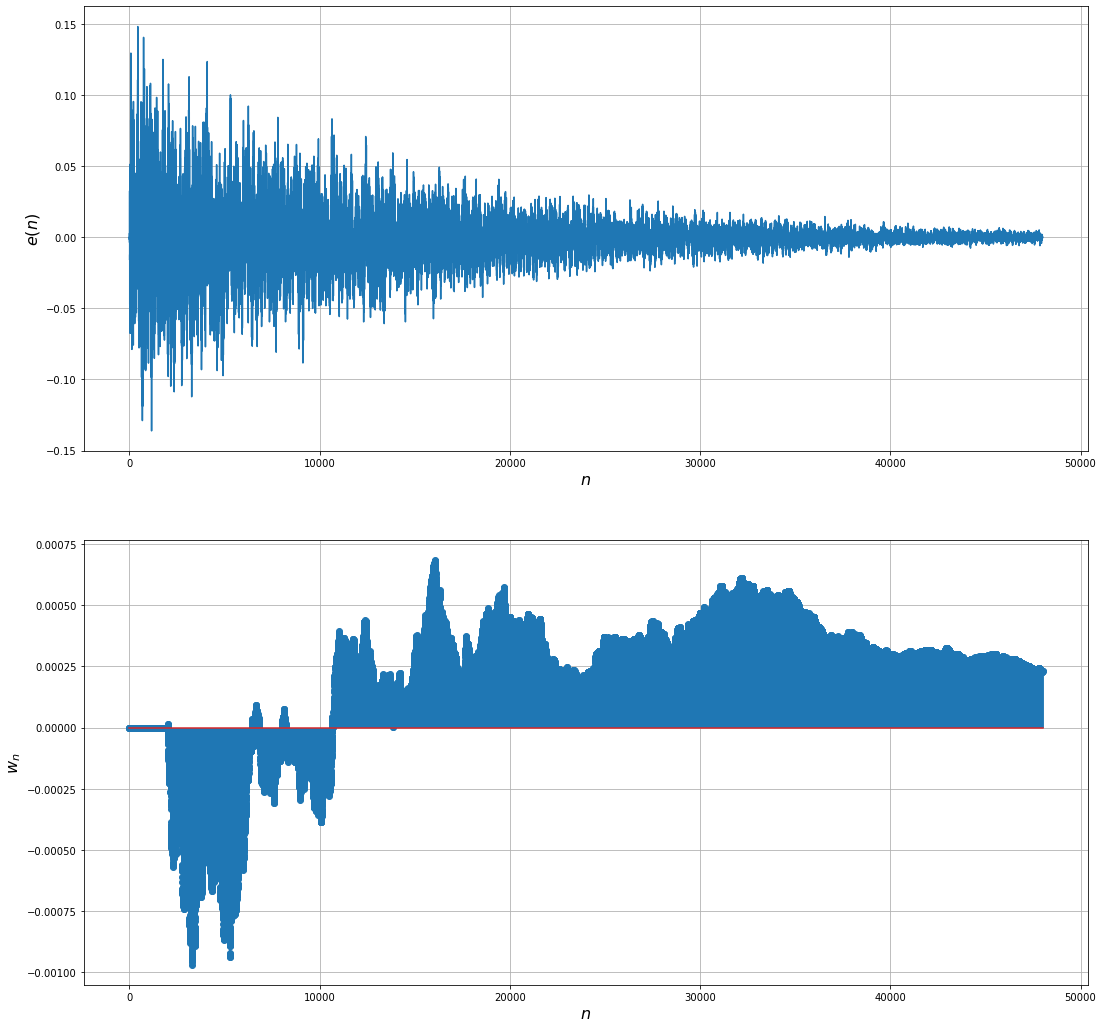

In [22]:
plot_anc_results([it1_e], it1_w, weight_plot='response')

In [23]:
IPython.display.Audio(it1_e, rate=fs)

# 3. Compensando el camino acústico secundario $G(z)$
En esta sección, se propone una segunda iteración del sistema para compensar el camino acústico secundario.

<table>
    <tr>
        <td><center><img src="../support/drawing/scheme_iteration_02.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/algorithm_iteration_02.png" style='width: 600px;'></center></td>
    </tr>
</table>

Se utilizará el ruido blanco para estudiar el comportamiento de esta iteración

In [822]:
x = airport_noise[0]
x /= x.max()

In [823]:
def anc_primary_secondary(model, g, order, step, w=None):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path and compensating the 
        secondary acoustic path.
        
        @param model Instance of an acoustic model for simulation
        @param g Secondary acoustic path
        @param order Order of the filter
        @param step Step size used for LMS
        @return Tuple containing error and coefficients of each iteration of the LMS algorithm
                (error_signal, coefficients_evolution)
    """
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    rg = np.zeros(len(g))      # Buffer for the input of G(z)
    rw = np.zeros(order)       # Buffer for the input of W(z)
    rlms = np.zeros(order)     # Buffer for the input of the LMS update equation
    e_n = np.zeros(N)
    w_n = np.zeros((order, N))
    if w is None:
        w = np.zeros(order)
    i = 0
    
    # Sample processing loop
    while (model.step()):
        rg = np.roll(rg, 1)
        rw = np.roll(rw, 1)
        rlms = np.roll(rlms, 1)
        
        rg[0] = rw[0] = model.reference_microphone()
        
        y = -np.dot(w, rw)
        model.speaker(y)
        
        e = model.error_microphone()
        e_n[i] = e
        
        rlms[0] = np.dot(g, rg)
        w += step * rlms * e
        w_n[:,i] = w
        
        i += 1
    
    return e_n, w_n

In [824]:
# Create the simulated headphone and the test noise
headphone = BoseQC20('../samples/BoseQC20.json', secondary_enable=True)
# headphone = Test(secondary_enable=True)
headphone.set_noise(x)

In [825]:
# Run iteration 1 of the algorithm, now with a secondary path in the headphone
headphone.reset()
it1_e_s, it1_w_s = anc_primary(headphone, order=3000, step=0.000015)

In [831]:
# Run the 2nd iteration of the algorithm
headphone.reset()
it2_e, it2_w = anc_primary_secondary(headphone, [0] * 4 + [0.23], order=5000, step=0.0002)

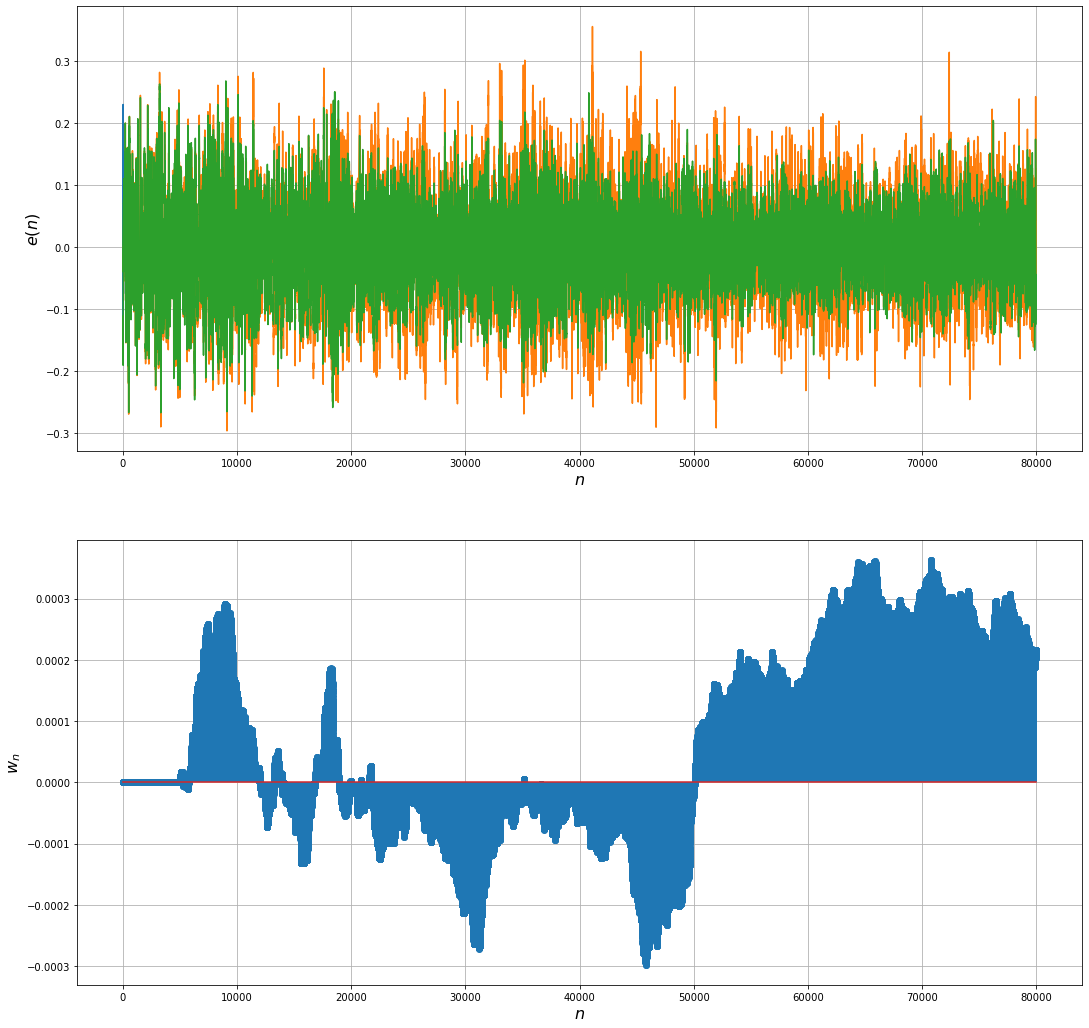

In [832]:
# Plot the ANC results
plot_anc_results([headphone.g, it1_e_s, it2_e], it2_w, weight_plot='response')

In [707]:
# Listen the audio
IPython.display.Audio(it2_e, rate=fs, normalize=False)

# 3. Compensando el camino acústico primario $P(z)$ y agregando NLMS
En esta sección, se propone una segunda iteración del sistema que considera la variación en la energía de entrada del ruido a cancelar, y ajusta el parámetro de paso acordemente.

<table>
    <tr>
        <td><center><img src="../support/drawing/scheme_iteration_03.png" style='width: 480px;'></center></td>
        <td><center><img src="../support/drawing/algorithm_iteration_03.png" style='width: 600px;'></center></td>
    </tr>
</table>

Se utilizará el ruido de subte para estudiar el comportamiento de esta iteración, debido a que se observó que es de los que más variación tiene en su energía. Primero se muestra el comportamiento del sistema como está hasta este punto, para este ruido con energía variable.

### Ruido de subte

In [950]:
x = subway_noise[0]
x /= x.max()

In [947]:
def anc_primary_nlms(model, order, step, delta=1e-7):
    """ Active Noise Cancelling
        Apply the active noise cancelling algorithm to compensate the
        noise by modeling the primary acoustic path.
        
        @param model Instance of an acoustic model for simulation
        @param order Order of the filter
        @param step Step size used for LMS
        @return Tuple containing the error signal and the coefficients evolution
                (error_signal, coefficients_evolution)
    """
    # Validate metaparameters
    if type(order) is int:
        if order < 1:
            raise ValueError("The minimum order is 1")
    else:
        raise ValueError("Order argument must be integer")
    if step <= 0:
        raise ValueError("The step size must be a positive value")
        
    # Parameters
    N = len(model)
    
    # Initialize arrays
    r = np.zeros(order)
    w = np.zeros(order)
    e_n = np.zeros(N)
    w_n = np.zeros((order, N))
    i = 0
    
    # Sample processing loop
    while (model.step()):
        # Take a new input sample and update the input buffer of the digital filter
        # by rolling the numpy array one place and introducing the new sample
        r = np.roll(r, 1)
        r[0] = model.reference_microphone()

        # Compute the output sample
        y = -np.dot(w, r)
        model.speaker(y)

        # Take a new error sample
        e = model.error_microphone()

        # Update the digital filter coefficients
        w += step / ((np.dot(r, r) / len(r)) + delta) * r * e

        # Save history
        e_n[i] = e
        w_n[:,i] = w
        i += 1
    
    return e_n, w_n

In [909]:
headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
it3_e, it3_w = anc_primary(headphone, order=2000, step=0.015)

Se compara en el siguiente gráfico la señal de error del sistema ANC (naranja) con la señal atenuada por el propio auricular (pasando por $ P(z) $), es decir, la atenuación pasiva (azul).

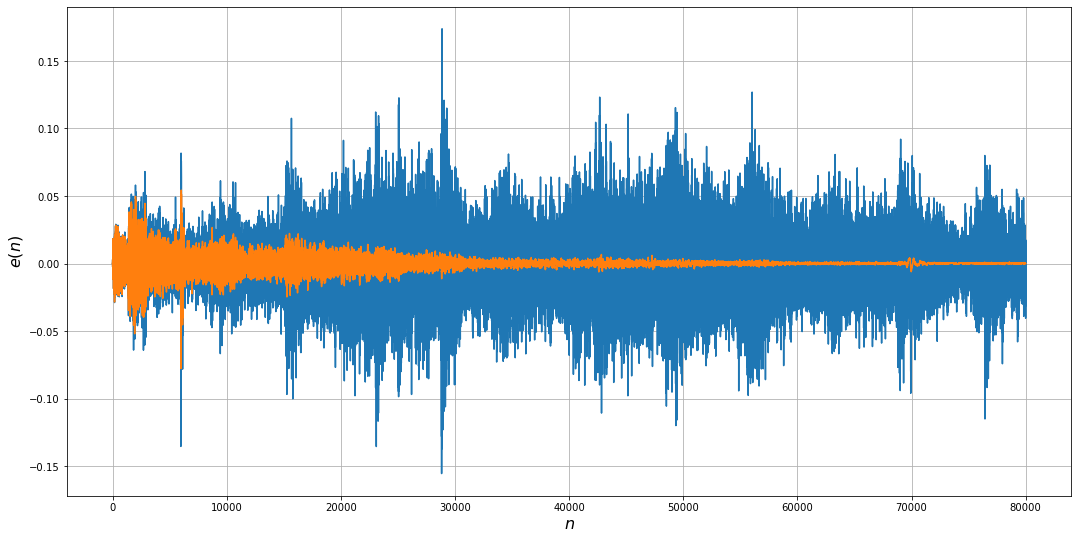

In [910]:
plot_anc_results([headphone.d, it3_e])

In [911]:
IPython.display.Audio(it3_e*10, rate=fs, normalize=False)

Se observa que si bien el sistema funciona a la larga, en varios puntos donde se observan cambios en la energía de la señal de entrada, la señal de error es suceptible a ellos y crece. Los valores en torno a la muestra 15000 y 70000 son claros ejemplos de esto. La introducción de NMLS viene justamente a suplir estas falencias.

In [951]:
headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
it3_e_n, it3_w_n = anc_primary_nlms(headphone, order=2000, step=0.0005, delta=1e-7)

Ahora se superpone a las señales de cancelación pasiva (azul) y error del LMS con el camino primario (naranja), el error obtenido de aplicar NLMS a la compensación del camino primario (verde). Para la normalización se utiliza una estimación de la energía de entrada dada por:

$$ || r(n) ||^2 \approx \frac{1}{N} \sum_{k=0}^{N-1} r^2(n-k) $$

Donde $ N $ es el orden del filtro adaptativo utilizado, ya que si se asume estacionareidad local para esa cantidad de muestras, también será valido el mismo criterio para la estimación de la energía.
Para protejerse contra problemas numéricos debido a posibles partes de la señal en que la energía sea muy baja (y que esto afecte negativamente al estar dividiendo), se incorpora una constante $ \delta $ en la actualización del parámetro de paso, de forma que:

$$ \mu = \frac{\tilde{\mu}}{|| r(n) ||^2 + \delta} $$

Se elige $ \delta = 1 \cdot 10^{-7} $ ya que se observó que ese valor se encuentra un órden de magnitud por debajo de los valores usuales más bajos de energía de entrada. En consecuencia, evita problemas excepcionales por energía de entrada inusualmente baja, y en condiciones normales es un término despreciable.

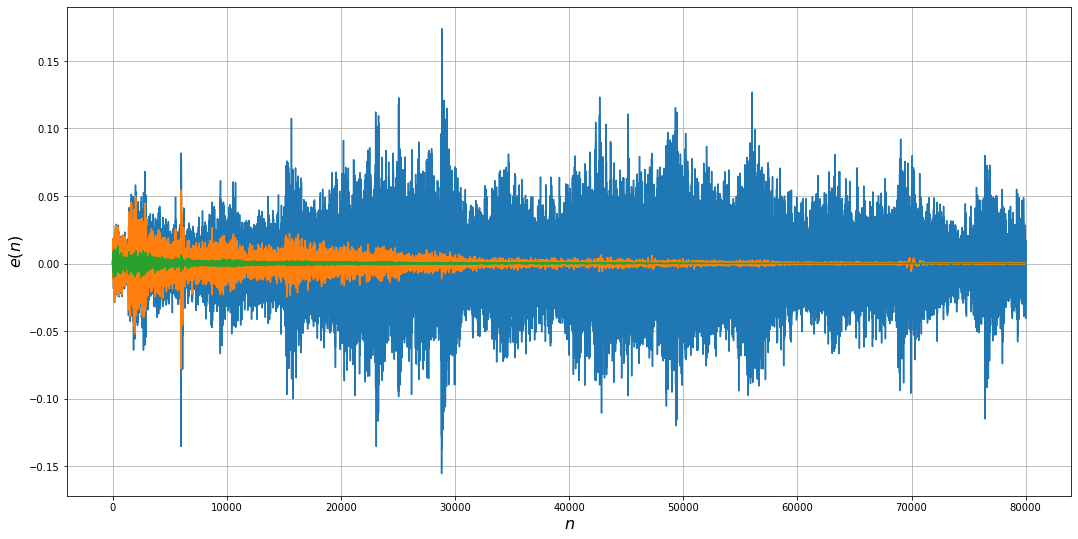

In [952]:
plot_anc_results([headphone.d, it3_e, it3_e_n])

In [933]:
IPython.display.Audio(it3_e_n*10, rate=fs, normalize=False)

En primer lugar, se observan mejorías considerables en la velocidad de convergencia, respecto del algoritmo con LMS, pero más importante, en lo que respecta al uso de NLMS, es la invarianza lograda ante las variaciones de energía en la señal de entrada. En zonas donde la iteración previa sufría estos cambios (en torno a las muestras 15000 y 70000), ahora la nueva iteración no presenta cambios en su error, indicando un ajuste en línea del parámetro de paso adecuado.

A continuación se probará de utilizar el mismo parámetro de paso que se empleó previamente para el ruido de subte, pero para los otros contextos de ruido, para verificar que sin importar el tipo de señal que se reciba ni su energía, el uso de NLMS se adapta a esto contextos.

### Ruido blanco

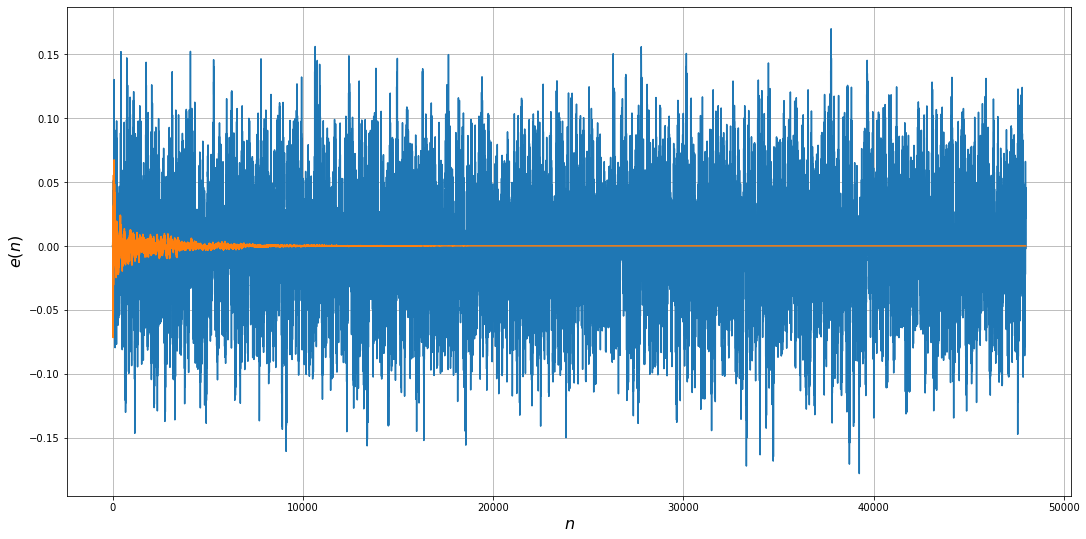

In [939]:
x = white_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de aeropuerto

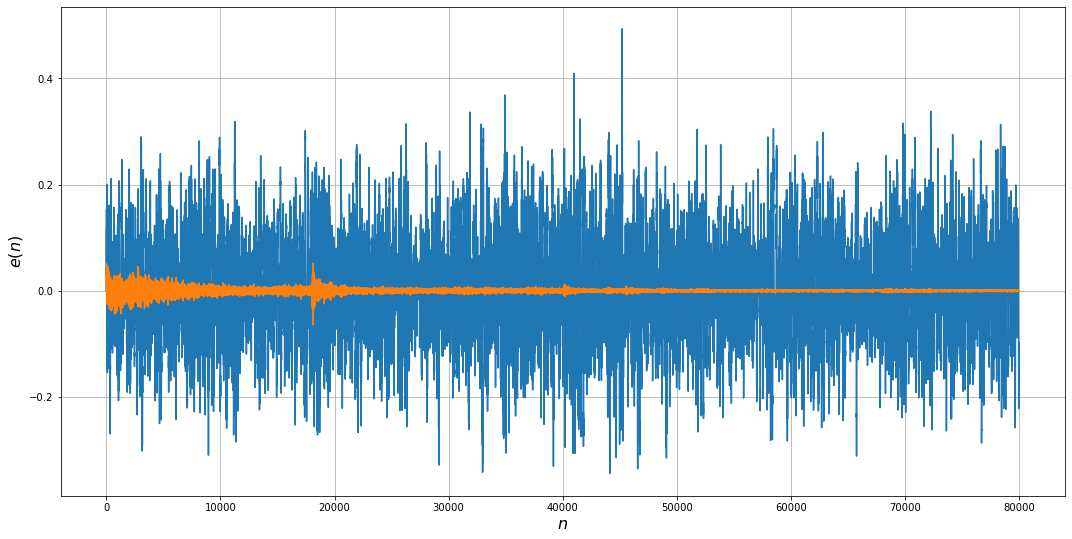

In [940]:
x = airport_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de auto

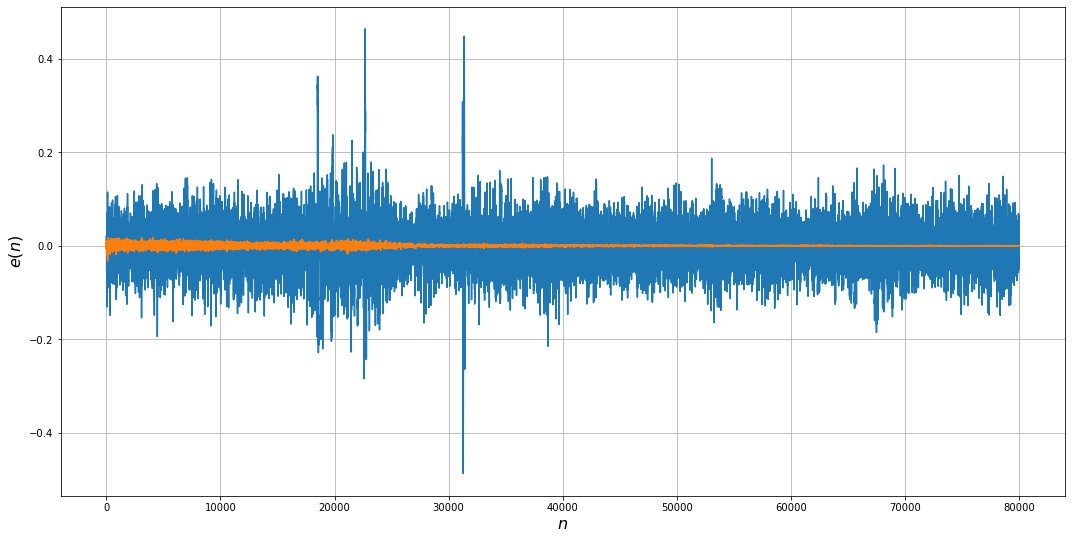

In [944]:
x = car_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de exhibición

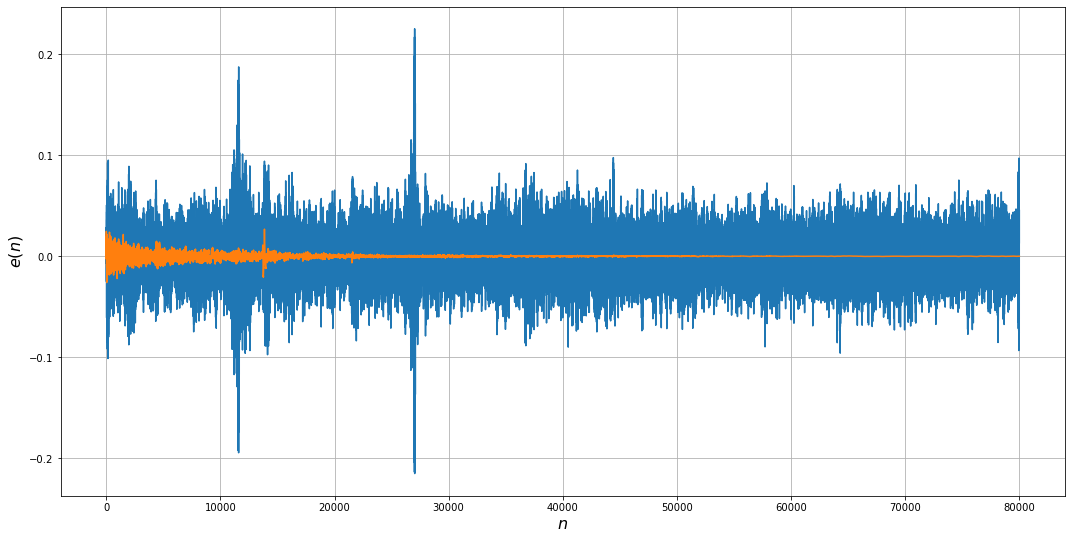

In [941]:
x = exhibition_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de restaurante

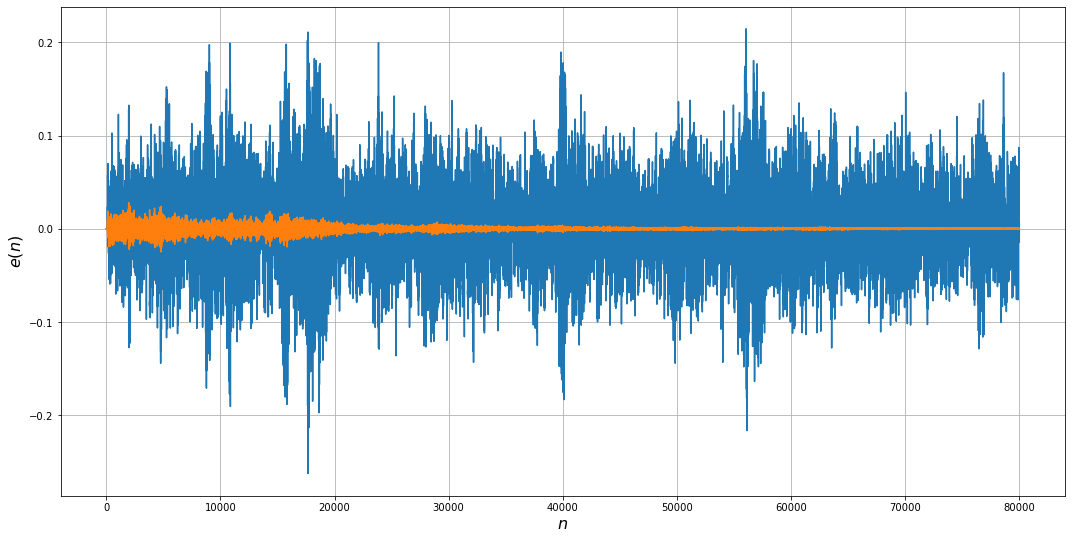

In [942]:
x = restaurant_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de calle

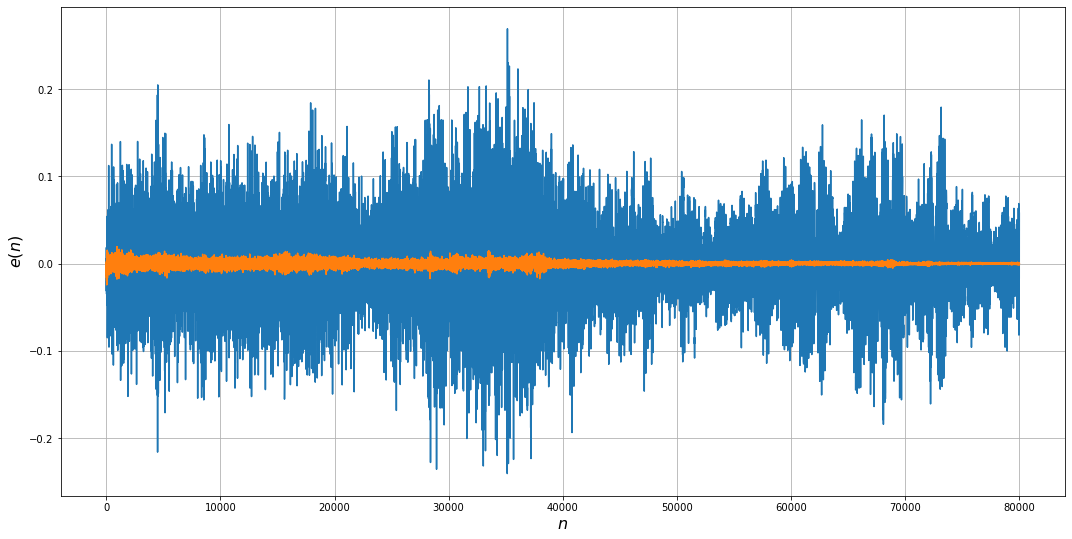

In [943]:
x = street_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

### Ruido de tren

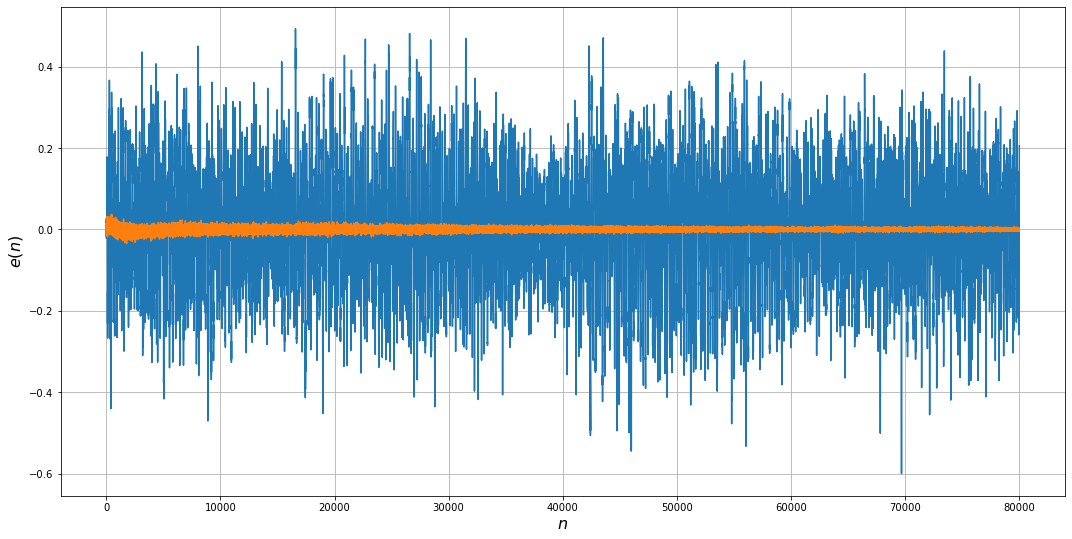

In [938]:
x = train_noise[0]
x /= x.max()

headphone = BoseQC20('../samples/BoseQC20.json')
headphone.set_noise(x)
error, _ = anc_primary_nlms(headphone, order=2000, step=0.0005)
plot_anc_results([headphone.d, error])

Del análisis de los gráficos anteriores, se deduce que la utilización de NLMS fue propiciosa, ya que el algorítmo muestra compensar las variaciones en la energía de entrada, para distintos contextos de ruido, y todo bajo el mismo parámetro de paso.